# GAN  `Model.train_step`

(https://twitter.com/fchollet)


## Загрузка модулей

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

## строим Fashion_MNIST data

In [2]:
# fashion MNIST 
class_ = 2
batch_size = 64
(x_train, y), (x_test, yt) = keras.datasets.fashion_mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
ind_i = np.where(y == class_)
ind_it = np.where(yt == class_)
all_digits = all_digits[ind_i,:,:]
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
import matplotlib.pyplot as plt


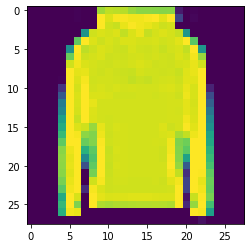

In [4]:
plt.imshow(all_digits[101,:,:,0])
plt.show()

## Строим discriminator

размер карты 28x28 и бинарная классификация (настоящее изображение или генерировано).

In [5]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 128)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                     

## Строим generator

обратное по отношению к дискриминатору преобразование, меняем `Conv2D` на `Conv2DTranspose` .

In [6]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 256)      524544    
 ranspose)                                               

## Класс со своим этапом обучения `train_step`

In [7]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным в текзор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}


## Callback для сохранения изображений по ходу обучения

In [8]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        image = generated_images.numpy()
        plt.figure(figsize = (self.num_img*4, 4))
        for i in range(self.num_img):
          plt.subplot(1,self.num_img,i+1)
          plt.imshow(image[i,:,:,0])
        plt.show()
        #for i in range(self.num_img):
        #    img = keras.preprocessing.image.array_to_img(generated_images[i])
        #    img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


## Учим end-to-end модель

Epoch 1/40
94/94 [==============================] - ETA: 0s - d_loss: 0.4664 - g_loss: 0.8683

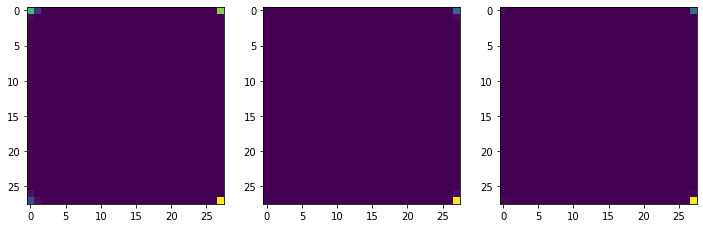

94/94 [==============================] - 25s 94ms/step - d_loss: 0.4637 - g_loss: 0.8734
Epoch 2/40
94/94 [==============================] - ETA: 0s - d_loss: 0.4848 - g_loss: 2.2550

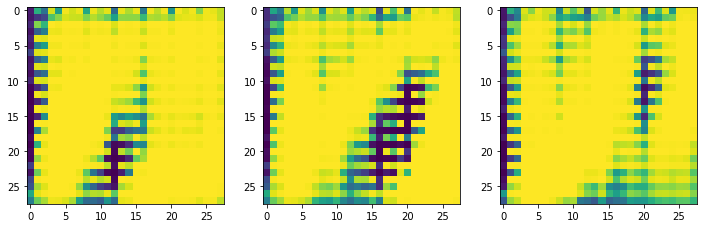

94/94 [==============================] - 8s 86ms/step - d_loss: 0.4885 - g_loss: 2.2402
Epoch 3/40
94/94 [==============================] - ETA: 0s - d_loss: 0.6767 - g_loss: 0.9948

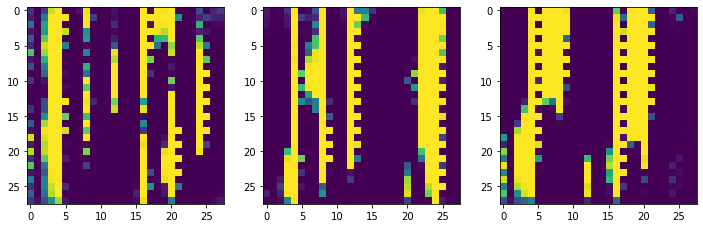

94/94 [==============================] - 8s 87ms/step - d_loss: 0.6729 - g_loss: 0.9990
Epoch 4/40
94/94 [==============================] - ETA: 0s - d_loss: 0.5234 - g_loss: 1.2568

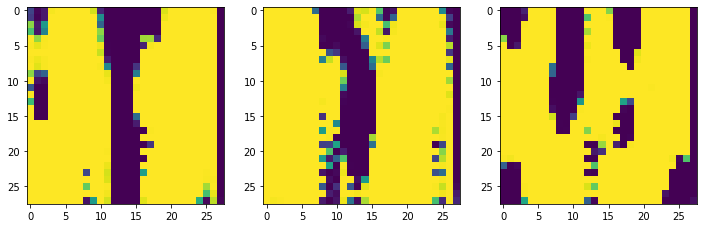

94/94 [==============================] - 8s 85ms/step - d_loss: 0.5229 - g_loss: 1.2560
Epoch 5/40
94/94 [==============================] - ETA: 0s - d_loss: 0.3679 - g_loss: 1.5211

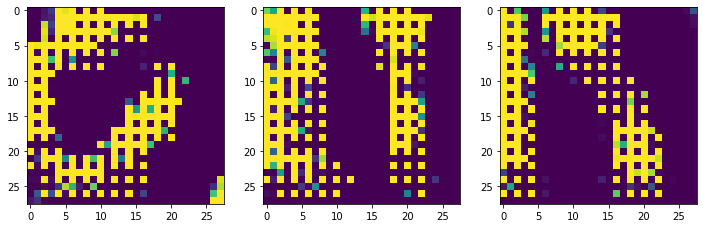

94/94 [==============================] - 8s 85ms/step - d_loss: 0.3700 - g_loss: 1.5165
Epoch 6/40
94/94 [==============================] - ETA: 0s - d_loss: 0.5572 - g_loss: 1.1721

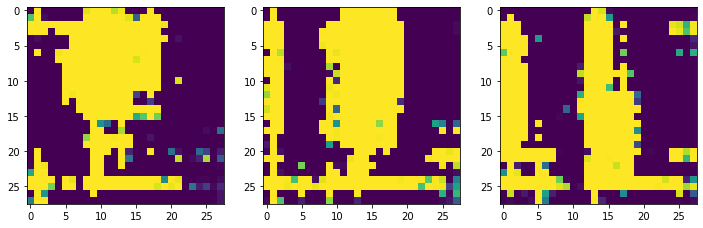

94/94 [==============================] - 8s 86ms/step - d_loss: 0.5569 - g_loss: 1.1726
Epoch 7/40
94/94 [==============================] - ETA: 0s - d_loss: 0.4410 - g_loss: 1.3342

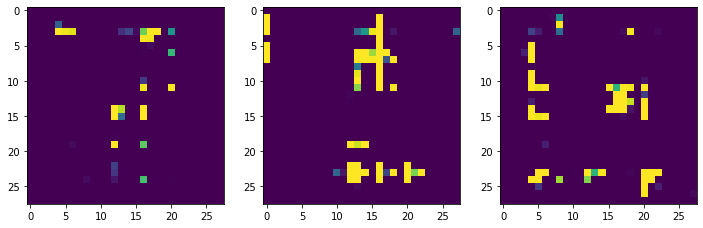

94/94 [==============================] - 8s 87ms/step - d_loss: 0.4400 - g_loss: 1.3341
Epoch 8/40
94/94 [==============================] - ETA: 0s - d_loss: 0.3660 - g_loss: 1.5062

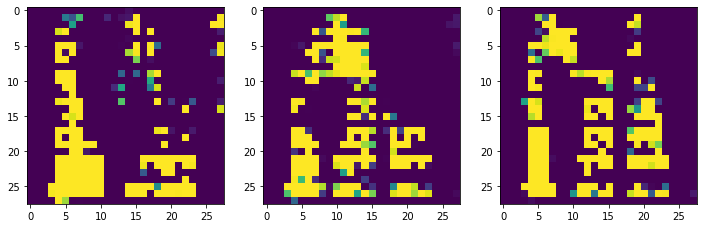

94/94 [==============================] - 8s 86ms/step - d_loss: 0.3661 - g_loss: 1.5067
Epoch 9/40
94/94 [==============================] - ETA: 0s - d_loss: 0.2979 - g_loss: 1.9407

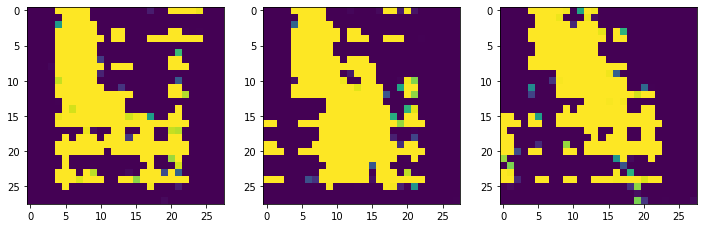

94/94 [==============================] - 8s 85ms/step - d_loss: 0.2982 - g_loss: 1.9373
Epoch 10/40
94/94 [==============================] - ETA: 0s - d_loss: 0.2554 - g_loss: 1.9299

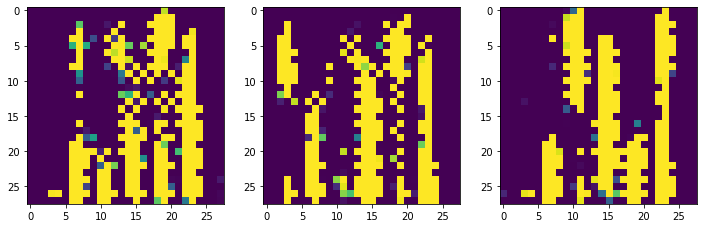

94/94 [==============================] - 8s 87ms/step - d_loss: 0.2558 - g_loss: 1.9272
Epoch 11/40
94/94 [==============================] - ETA: 0s - d_loss: 0.1953 - g_loss: 2.3795

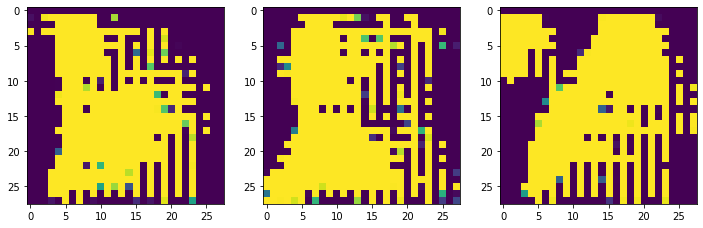

94/94 [==============================] - 8s 86ms/step - d_loss: 0.1956 - g_loss: 2.3771
Epoch 12/40
94/94 [==============================] - ETA: 0s - d_loss: 0.2086 - g_loss: 2.2265

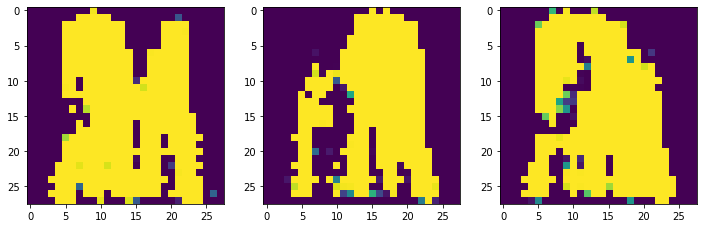

94/94 [==============================] - 8s 87ms/step - d_loss: 0.2081 - g_loss: 2.2275
Epoch 13/40
94/94 [==============================] - ETA: 0s - d_loss: 0.2305 - g_loss: 2.1156

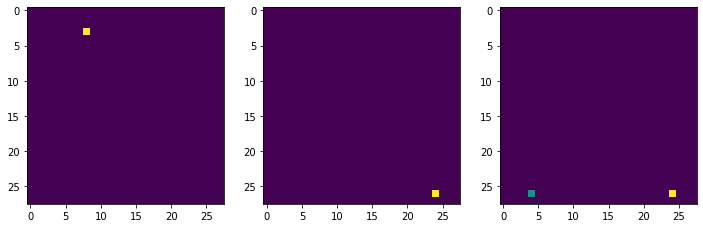

94/94 [==============================] - 8s 87ms/step - d_loss: 0.2292 - g_loss: 2.1180
Epoch 14/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0460 - g_loss: 5.3160

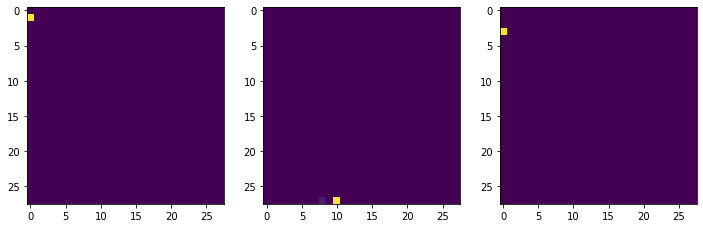

94/94 [==============================] - 8s 86ms/step - d_loss: 0.0457 - g_loss: 5.3252
Epoch 15/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0107 - g_loss: 6.7471

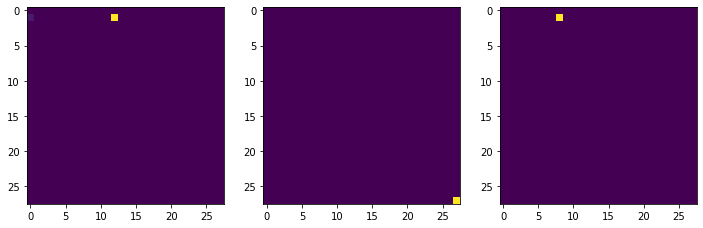

94/94 [==============================] - 8s 86ms/step - d_loss: 0.0105 - g_loss: 6.7525
Epoch 16/40
94/94 [==============================] - ETA: 0s - d_loss: -0.0128 - g_loss: 7.9027

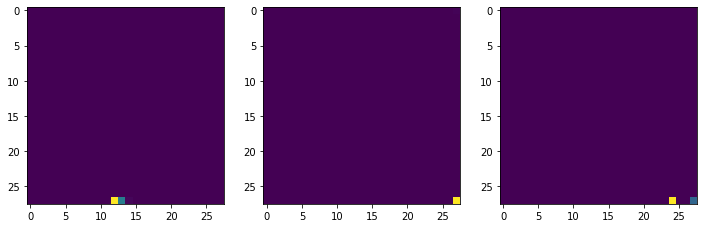

94/94 [==============================] - 8s 88ms/step - d_loss: -0.0128 - g_loss: 7.9094
Epoch 17/40
94/94 [==============================] - ETA: 0s - d_loss: -0.0305 - g_loss: 9.3034

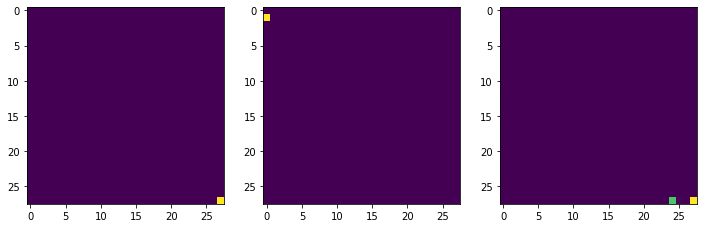

94/94 [==============================] - 8s 86ms/step - d_loss: -0.0306 - g_loss: 9.3107
Epoch 18/40
94/94 [==============================] - ETA: 0s - d_loss: -0.0479 - g_loss: 10.8587

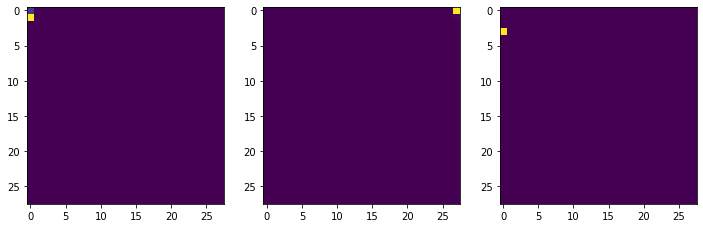

94/94 [==============================] - 8s 86ms/step - d_loss: -0.0478 - g_loss: 10.8680
Epoch 19/40
94/94 [==============================] - ETA: 0s - d_loss: -0.0742 - g_loss: 12.8935

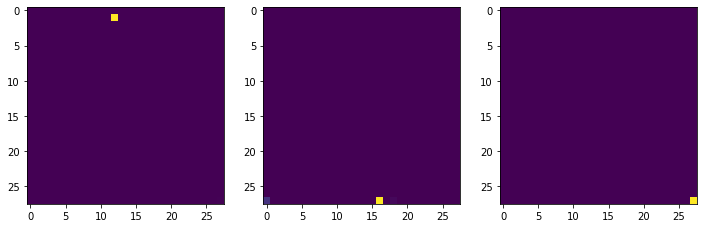

94/94 [==============================] - 8s 86ms/step - d_loss: -0.0741 - g_loss: 12.9064
Epoch 20/40
94/94 [==============================] - ETA: 0s - d_loss: -0.1063 - g_loss: 15.5622

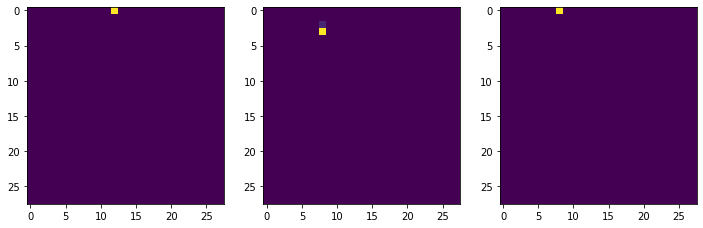

94/94 [==============================] - 8s 86ms/step - d_loss: -0.1062 - g_loss: 15.5795
Epoch 21/40
94/94 [==============================] - ETA: 0s - d_loss: -0.1487 - g_loss: 19.2267

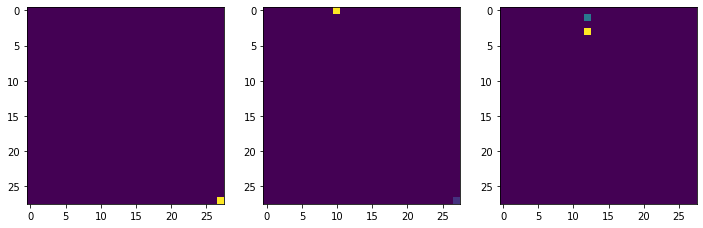

94/94 [==============================] - 8s 86ms/step - d_loss: -0.1489 - g_loss: 19.2477
Epoch 22/40
94/94 [==============================] - ETA: 0s - d_loss: -0.2051 - g_loss: 24.1931

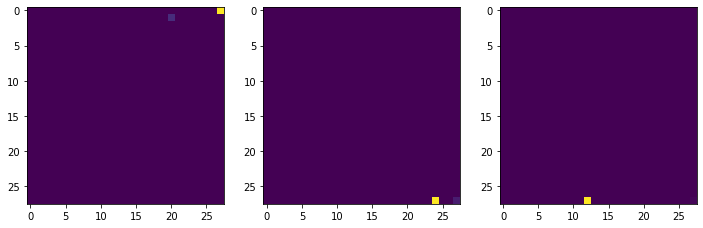

94/94 [==============================] - 8s 87ms/step - d_loss: -0.2045 - g_loss: 24.2246
Epoch 23/40
94/94 [==============================] - ETA: 0s - d_loss: -0.2814 - g_loss: 31.1541

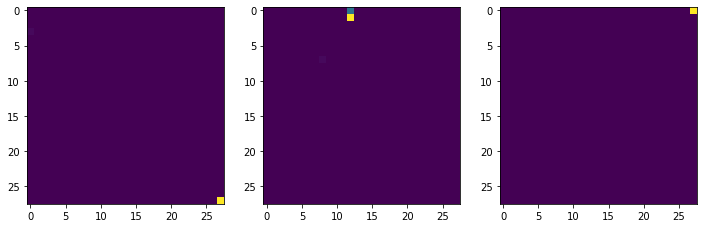

94/94 [==============================] - 8s 86ms/step - d_loss: -0.2821 - g_loss: 31.1991
Epoch 24/40
94/94 [==============================] - ETA: 0s - d_loss: -0.4046 - g_loss: 41.4670

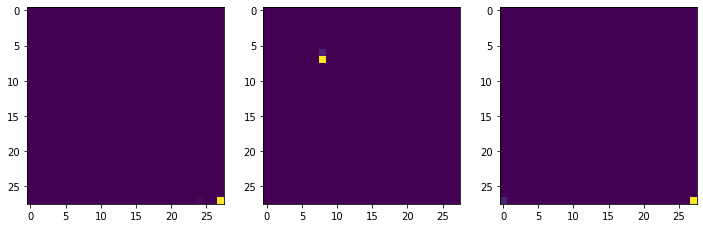

94/94 [==============================] - 8s 86ms/step - d_loss: -0.4062 - g_loss: 41.5370
Epoch 25/40
94/94 [==============================] - ETA: 0s - d_loss: -0.5806 - g_loss: 57.0484

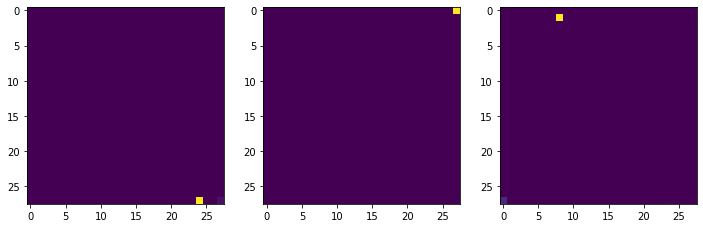

94/94 [==============================] - 8s 87ms/step - d_loss: -0.5824 - g_loss: 57.1554
Epoch 26/40
94/94 [==============================] - ETA: 0s - d_loss: -0.8630 - g_loss: 80.9174

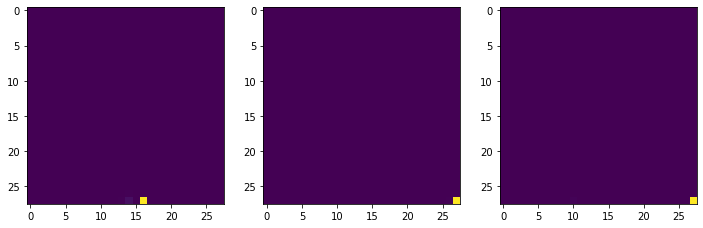

94/94 [==============================] - 8s 87ms/step - d_loss: -0.8616 - g_loss: 81.0766
Epoch 27/40
94/94 [==============================] - ETA: 0s - d_loss: -1.1431 - g_loss: 109.9858

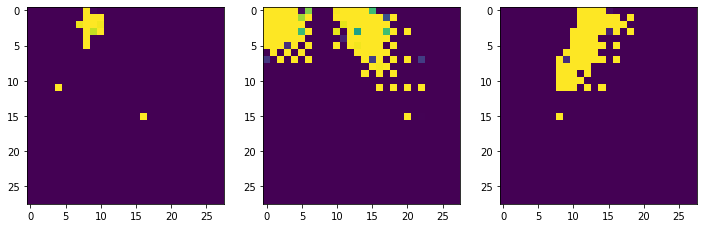

94/94 [==============================] - 8s 87ms/step - d_loss: -1.1208 - g_loss: 109.0137
Epoch 28/40
94/94 [==============================] - ETA: 0s - d_loss: 0.7710 - g_loss: 4.9931

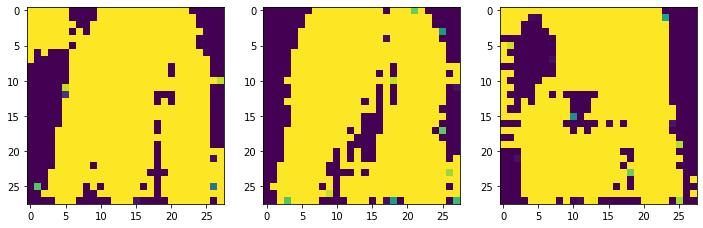

94/94 [==============================] - 8s 87ms/step - d_loss: 0.7663 - g_loss: 4.9615
Epoch 29/40
94/94 [==============================] - ETA: 0s - d_loss: 0.2514 - g_loss: 2.7510

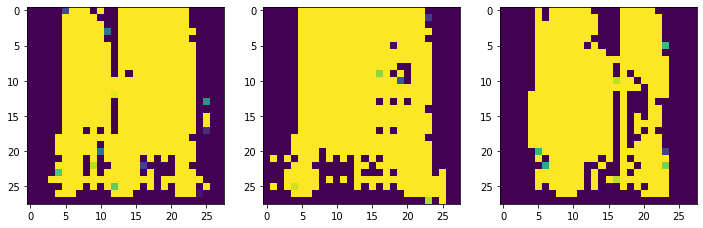

94/94 [==============================] - 8s 90ms/step - d_loss: 0.2511 - g_loss: 2.7549
Epoch 30/40
94/94 [==============================] - ETA: 0s - d_loss: 0.2381 - g_loss: 3.2168

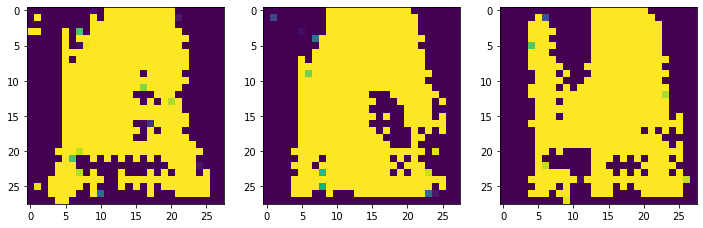

94/94 [==============================] - 8s 87ms/step - d_loss: 0.2391 - g_loss: 3.2119
Epoch 31/40
94/94 [==============================] - ETA: 0s - d_loss: 0.4304 - g_loss: 3.8356

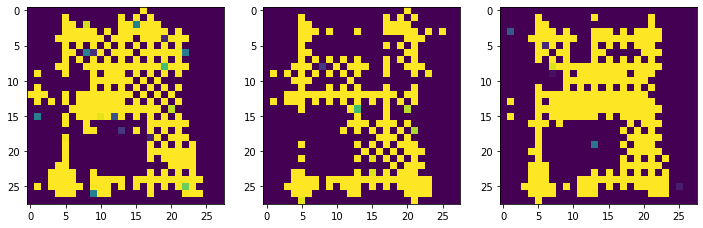

94/94 [==============================] - 8s 87ms/step - d_loss: 0.4370 - g_loss: 3.8263
Epoch 32/40
81/94 [========================>.....] - ETA: 1s - d_loss: 0.3390 - g_loss: 7.1801

In [ ]:
epochs = 40

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Display the last generated images:

In [ ]:
history = gan.fit(
    dataset, epochs=40, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.plot(history.history['d_loss'])
plt.title('d_loss')
plt.xlabel('epoch')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(history.history['g_loss'])
plt.title('g_loss')
plt.xlabel('epoch')
plt.grid(True)
2

plt.show()

In [ ]:
I = gan.generator(tf.random.normal(shape=(1, gan.latent_dim)))

In [ ]:
plt.imshow(I[0,:,:,0])
plt.show()